# Методы машинного обучения.

## ЛР8. - Продолжение анализа социологического исследования из ЛР №4.

В имеющийся файл данных добавлена интегральная характеристика удовлетворенности человека жизнью - для ее описания используется шкала Кантрила (см. рисунок 1)

#### Субъективные показатели качества жизни

Шкала Кантрила (The Cantril Scale) – простая визуальная шкала, которая позволяет оценить общую удовлетворенность жизнью.

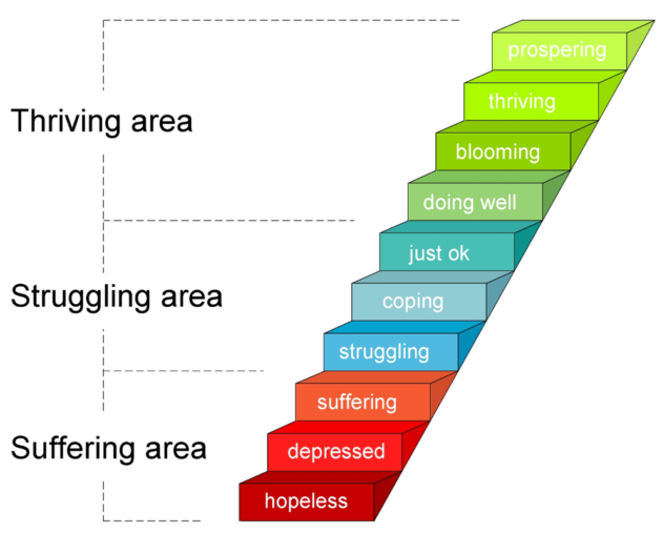

Рисунок 1. Шкала Кантрила.

- Prospering – Процветающий/благоденствующий
- Thriving – Преуспевающий
- Blooming – Расцветающий
- Doing well – Дела идут хорошо
- Just Ok – Просто нормально
- Coping – Справляющийся
- Struggling – Столкнувшийся с трудностями/борющийся
- Suffering – Страдающий
- Depressed – Депрессивный
- Hopeless – Безнадежный

Задание:
- Определить какие из признаков состояния наиболее сильно связаны с интегральной оценкой счастья (благополучия) респондента.
- Пользуясь найденными закономерностями спрогнозировать попадание респондентов, у которых интегральная характеристика отмечена как "Неизвестно", в укрупненные группы шкалы Кантрила. Построить следующие классификаторы: многоклассовую логистическую регрессию, дерево решений, ансамблевый классификатор. Сравнить матрицы ошибок и метрики качества классификации.

## Выполнение

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from operator import itemgetter
from scipy.special import expit

pd.options.mode.copy_on_write = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ml_lab_08/ММО_ЛР8_Исходные_данные.xlsx')
dataset

Респондент       Сообщество  Среднегодовой.доход,.тыс..$  \
0          Респондент 1  Сообщество  480                       21.350   
1          Респондент 2  Сообщество  130                      622.613   
2          Респондент 3  Сообщество  156                      400.896   
3          Респондент 4   Сообщество  69                      375.950   
4          Респондент 5  Сообщество  330                      925.782   
...                 ...              ...                          ...   
35995  Респондент 35996  Сообщество  318                      412.715   
35996  Респондент 35997  Сообщество  384                      373.757   
35997  Респондент 35998  Сообщество  331                      374.882   
35998  Респондент 35999  Сообщество  402                      412.314   
35999  Респондент 36000  Сообщество  574                      264.142   

       Объем.потребленного.алкоголя.в.год,.л.  Количество.членов.семьи  \
0                                          62                        4   
1                                          30                        7   
2                                          45                        2   
3                                          56                        5   
4                                          39                        6   
...                                       ...                      ...   
35995                                      46                        3   
35996                                      48                        1   
35997                                      38                        1   
35998                                      51                        3   
35999                                      49                        1   

       Количество.лет.образования  \
0                               5   
1                              21   
2                               8   
3                              10   
4                              18   
...                           ...   
35995                          11   
35996                           8   
35997                          18   
35998                          12   
35999                          15   

       Доля.от.дохода.семьи.которая.тратится.на.продовольствие,.%  \
0                                                     65            
1                                                     39            
2                                                     45            
3                                                     68            
4                                                     38            
...                                                  ...            
35995                                                 50            
35996                                                 50            
35997                                                 39            
35998                                                 44            
35999                                                 45            

       Коэффициент.Джини.сообщества  \
0                          0.608084   
1                          0.369140   
2                          0.345094   
3                          0.635868   
4                          0.787911   
...                             ...   
35995                      0.921816   
35996                      0.620469   
35997                      0.498873   
35998                      0.663517   
35999                      0.561213   

       Издержки.сообщества.на.окружающую.среду,.млн..$  \
0                                               197.16   
1                                               297.10   
2                                               305.32   
3                                                78.78   
4                                                93.35   
...                                                ...   
35995                                            59.51   
35996                                   

## WARN!

Я забыл про файлик с данными для проверки, поэтому и обучающая, и тестовая выборки были взяты из выборки людей с известными данными. Концепция не ломается, просто можно было бы использовать больше данных для обучения.

In [ ]:
na = set(dataset.columns).difference(dataset.dropna(axis=1).columns)
na

{'Индекс.Щедрости',
 'Индекс.кредитного.оптимизма',
 'Индекс.отношения.к.коррупции',
 'Индекс.продовольственной.безопасности',
 'Индекс.семьи',
 'Индекс.страха.социальных.конфликтов',
 'Ожидаемая.продолжительность.здоровой.жизни',
 'Оценка.благополучия',
 'Оценка.риска.безработицы',
 'Оценка.социальной.поддержки',
 'Свобода.граждан.самостоятельно.принимать.жизненно.важные.решения',
 'Чувство.неравенства.доходов.в.обществе',
 'Чувство.технологического.прогресса'}

In [ ]:
class_names = list(set(dataset['Ощущаемое.счастье']))
class_names

['Prospering',
 'Suffering',
 'Depressed',
 'Неизвестно',
 'Doing well',
 'Coping',
 'Just ok',
 'Thriving',
 'Blooming',
 'Strugglng',
 'Hopeless']

In [ ]:
dataset = dataset.drop(['Респондент'], axis=1)
dataset

Сообщество  Среднегодовой.доход,.тыс..$  \
0      Сообщество  480                       21.350   
1      Сообщество  130                      622.613   
2      Сообщество  156                      400.896   
3       Сообщество  69                      375.950   
4      Сообщество  330                      925.782   
...                ...                          ...   
35995  Сообщество  318                      412.715   
35996  Сообщество  384                      373.757   
35997  Сообщество  331                      374.882   
35998  Сообщество  402                      412.314   
35999  Сообщество  574                      264.142   

       Объем.потребленного.алкоголя.в.год,.л.  Количество.членов.семьи  \
0                                          62                        4   
1                                          30                        7   
2                                          45                        2   
3                                          56                        5   
4                                          39                        6   
...                                       ...                      ...   
35995                                      46                        3   
35996                                      48                        1   
35997                                      38                        1   
35998                                      51                        3   
35999                                      49                        1   

       Количество.лет.образования  \
0                               5   
1                              21   
2                               8   
3                              10   
4                              18   
...                           ...   
35995                          11   
35996                           8   
35997                          18   
35998                          12   
35999                          15   

       Доля.от.дохода.семьи.которая.тратится.на.продовольствие,.%  \
0                                                     65            
1                                                     39            
2                                                     45            
3                                                     68            
4                                                     38            
...                                                  ...            
35995                                                 50            
35996                                                 50            
35997                                                 39            
35998                                                 44            
35999                                                 45            

       Коэффициент.Джини.сообщества  \
0                          0.608084   
1                          0.369140   
2                          0.345094   
3                          0.635868   
4                          0.787911   
...                             ...   
35995                      0.921816   
35996                      0.620469   
35997                      0.498873   
35998                      0.663517   
35999                      0.561213   

       Издержки.сообщества.на.окружающую.среду,.млн..$  \
0                                               197.16   
1                                               297.10   
2                                               305.32   
3                                                78.78   
4                                                93.35   
...                                                ...   
35995                                            59.51   
35996                                           144.79   
35997                                           207.14   
35998                                           108.70   
35999                                           190.08   

       Охват.беспровод

In [ ]:
dataset['Сообщество'] = dataset['Сообщество'].apply(lambda it: re.findall(r'\b\d+\b', it)[0])
dataset

Сообщество  Среднегодовой.доход,.тыс..$  \
0            480                       21.350   
1            130                      622.613   
2            156                      400.896   
3             69                      375.950   
4            330                      925.782   
...          ...                          ...   
35995        318                      412.715   
35996        384                      373.757   
35997        331                      374.882   
35998        402                      412.314   
35999        574                      264.142   

       Объем.потребленного.алкоголя.в.год,.л.  Количество.членов.семьи  \
0                                          62                        4   
1                                          30                        7   
2                                          45                        2   
3                                          56                        5   
4                                          39                        6   
...                                       ...                      ...   
35995                                      46                        3   
35996                                      48                        1   
35997                                      38                        1   
35998                                      51                        3   
35999                                      49                        1   

       Количество.лет.образования  \
0                               5   
1                              21   
2                               8   
3                              10   
4                              18   
...                           ...   
35995                          11   
35996                           8   
35997                          18   
35998                          12   
35999                          15   

       Доля.от.дохода.семьи.которая.тратится.на.продовольствие,.%  \
0                                                     65            
1                                                     39            
2                                                     45            
3                                                     68            
4                                                     38            
...                                                  ...            
35995                                                 50            
35996                                                 50            
35997                                                 39            
35998                                                 44            
35999                                                 45            

       Коэффициент.Джини.сообщества  \
0                          0.608084   
1                          0.369140   
2                          0.345094   
3                          0.635868   
4                          0.787911   
...                             ...   
35995                      0.921816   
35996                      0.620469   
35997                      0.498873   
35998                      0.663517   
35999                      0.561213   

       Издержки.сообщества.на.окружающую.среду,.млн..$  \
0                                               197.16   
1                                               297.10   
2                                               305.32   
3                                                78.78   
4                                                93.35   
...                                                ...   
35995                                            59.51   
35996                                           144.79   
35997                                           207.14   
35998                                           108.70   
35999                                           190.08   

       Охват.беспроводной.связи.в.сообществе,.%  \
0                                    

In [ ]:
dataset_unknowns = dataset[dataset['Ощущаемое.счастье'] == 'Неизвестно']
dataset_unknowns

Сообщество  Среднегодовой.доход,.тыс..$  \
6            494                      833.042   
14           206                      101.207   
20            56                      627.500   
32           261                       93.401   
33           405                      715.802   
...          ...                          ...   
35978        264                      360.371   
35981        302                      745.104   
35991        525                      173.444   
35996        384                      373.757   
35998        402                      412.314   

       Объем.потребленного.алкоголя.в.год,.л.  Количество.членов.семьи  \
6                                          34                        2   
14                                         65                        4   
20                                         51                        1   
32                                         50                        3   
33                                         39                        3   
...                                       ...                      ...   
35978                                      38                        6   
35981                                      45                        6   
35991                                      72                        1   
35996                                      48                        1   
35998                                      51                        3   

       Количество.лет.образования  \
6                              18   
14                              4   
20                             13   
32                             10   
33                             24   
...                           ...   
35978                          20   
35981                          13   
35991                           5   
35996                           8   
35998                          12   

       Доля.от.дохода.семьи.которая.тратится.на.продовольствие,.%  \
6                                                     38            
14                                                    69            
20                                                    45            
32                                                    48            
33                                                    34            
...                                                  ...            
35978                                                 36            
35981                                                 44            
35991                                                 67            
35996                                                 50            
35998                                                 44            

       Коэффициент.Джини.сообщества  \
6                          0.291490   
14                         0.070392   
20                         0.897229   
32                         0.376128   
33                         0.000480   
...                             ...   
35978                      0.340375   
35981                      0.186150   
35991                      0.364146   
35996                      0.620469   
35998                      0.663517   

       Издержки.сообщества.на.окружающую.среду,.млн..$  \
6                                               296.46   
14                                              310.57   
20                                               40.58   
32                                              298.07   
33                                              369.99   
...                                                ...   
35978                                           248.53   
35981                                           311.63   
35991                                           246.84   
35996                                           144.79   
35998                                           108.70   

       Охват.беспроводной.связи.в.сообществе,.%  \
6                                    

In [ ]:
dataset_knowns = dataset[dataset['Ощущаемое.счастье'] != 'Неизвестно']
dataset_knowns

Сообщество  Среднегодовой.доход,.тыс..$  \
0            480                       21.350   
1            130                      622.613   
2            156                      400.896   
3             69                      375.950   
4            330                      925.782   
...          ...                          ...   
35993        450                      458.691   
35994        567                      418.492   
35995        318                      412.715   
35997        331                      374.882   
35999        574                      264.142   

       Объем.потребленного.алкоголя.в.год,.л.  Количество.членов.семьи  \
0                                          62                        4   
1                                          30                        7   
2                                          45                        2   
3                                          56                        5   
4                                          39                        6   
...                                       ...                      ...   
35993                                      47                        1   
35994                                      54                        2   
35995                                      46                        3   
35997                                      38                        1   
35999                                      49                        1   

       Количество.лет.образования  \
0                               5   
1                              21   
2                               8   
3                              10   
4                              18   
...                           ...   
35993                          14   
35994                          11   
35995                          11   
35997                          18   
35999                          15   

       Доля.от.дохода.семьи.которая.тратится.на.продовольствие,.%  \
0                                                     65            
1                                                     39            
2                                                     45            
3                                                     68            
4                                                     38            
...                                                  ...            
35993                                                 50            
35994                                                 47            
35995                                                 50            
35997                                                 39            
35999                                                 45            

       Коэффициент.Джини.сообщества  \
0                          0.608084   
1                          0.369140   
2                          0.345094   
3                          0.635868   
4                          0.787911   
...                             ...   
35993                      0.356139   
35994                      0.841676   
35995                      0.921816   
35997                      0.498873   
35999                      0.561213   

       Издержки.сообщества.на.окружающую.среду,.млн..$  \
0                                               197.16   
1                                               297.10   
2                                               305.32   
3                                                78.78   
4                                                93.35   
...                                                ...   
35993                                           260.35   
35994                                            21.94   
35995                                            59.51   
35997                                           207.14   
35999                                           190.08   

       Охват.беспроводной.связи.в.сообществе,.%  \
0                                    

In [ ]:
dataset_knowns['Ощущаемое.счастье'] = dataset_knowns['Ощущаемое.счастье'].apply(lambda it: class_names.index(it))
dataset_knowns

Сообщество  Среднегодовой.доход,.тыс..$  \
0            480                       21.350   
1            130                      622.613   
2            156                      400.896   
3             69                      375.950   
4            330                      925.782   
...          ...                          ...   
35993        450                      458.691   
35994        567                      418.492   
35995        318                      412.715   
35997        331                      374.882   
35999        574                      264.142   

       Объем.потребленного.алкоголя.в.год,.л.  Количество.членов.семьи  \
0                                          62                        4   
1                                          30                        7   
2                                          45                        2   
3                                          56                        5   
4                                          39                        6   
...                                       ...                      ...   
35993                                      47                        1   
35994                                      54                        2   
35995                                      46                        3   
35997                                      38                        1   
35999                                      49                        1   

       Количество.лет.образования  \
0                               5   
1                              21   
2                               8   
3                              10   
4                              18   
...                           ...   
35993                          14   
35994                          11   
35995                          11   
35997                          18   
35999                          15   

       Доля.от.дохода.семьи.которая.тратится.на.продовольствие,.%  \
0                                                     65            
1                                                     39            
2                                                     45            
3                                                     68            
4                                                     38            
...                                                  ...            
35993                                                 50            
35994                                                 47            
35995                                                 50            
35997                                                 39            
35999                                                 45            

       Коэффициент.Джини.сообщества  \
0                          0.608084   
1                          0.369140   
2                          0.345094   
3                          0.635868   
4                          0.787911   
...                             ...   
35993                      0.356139   
35994                      0.841676   
35995                      0.921816   
35997                      0.498873   
35999                      0.561213   

       Издержки.сообщества.на.окружающую.среду,.млн..$  \
0                                               197.16   
1                                               297.10   
2                                               305.32   
3                                                78.78   
4                                                93.35   
...                                                ...   
35993                                           260.35   
35994                                            21.94   
35995                                            59.51   
35997                                           207.14   
35999                                           190.08   

       Охват.беспроводной.связи.в.сообществе,.%  \
0                                    

<Axes: >

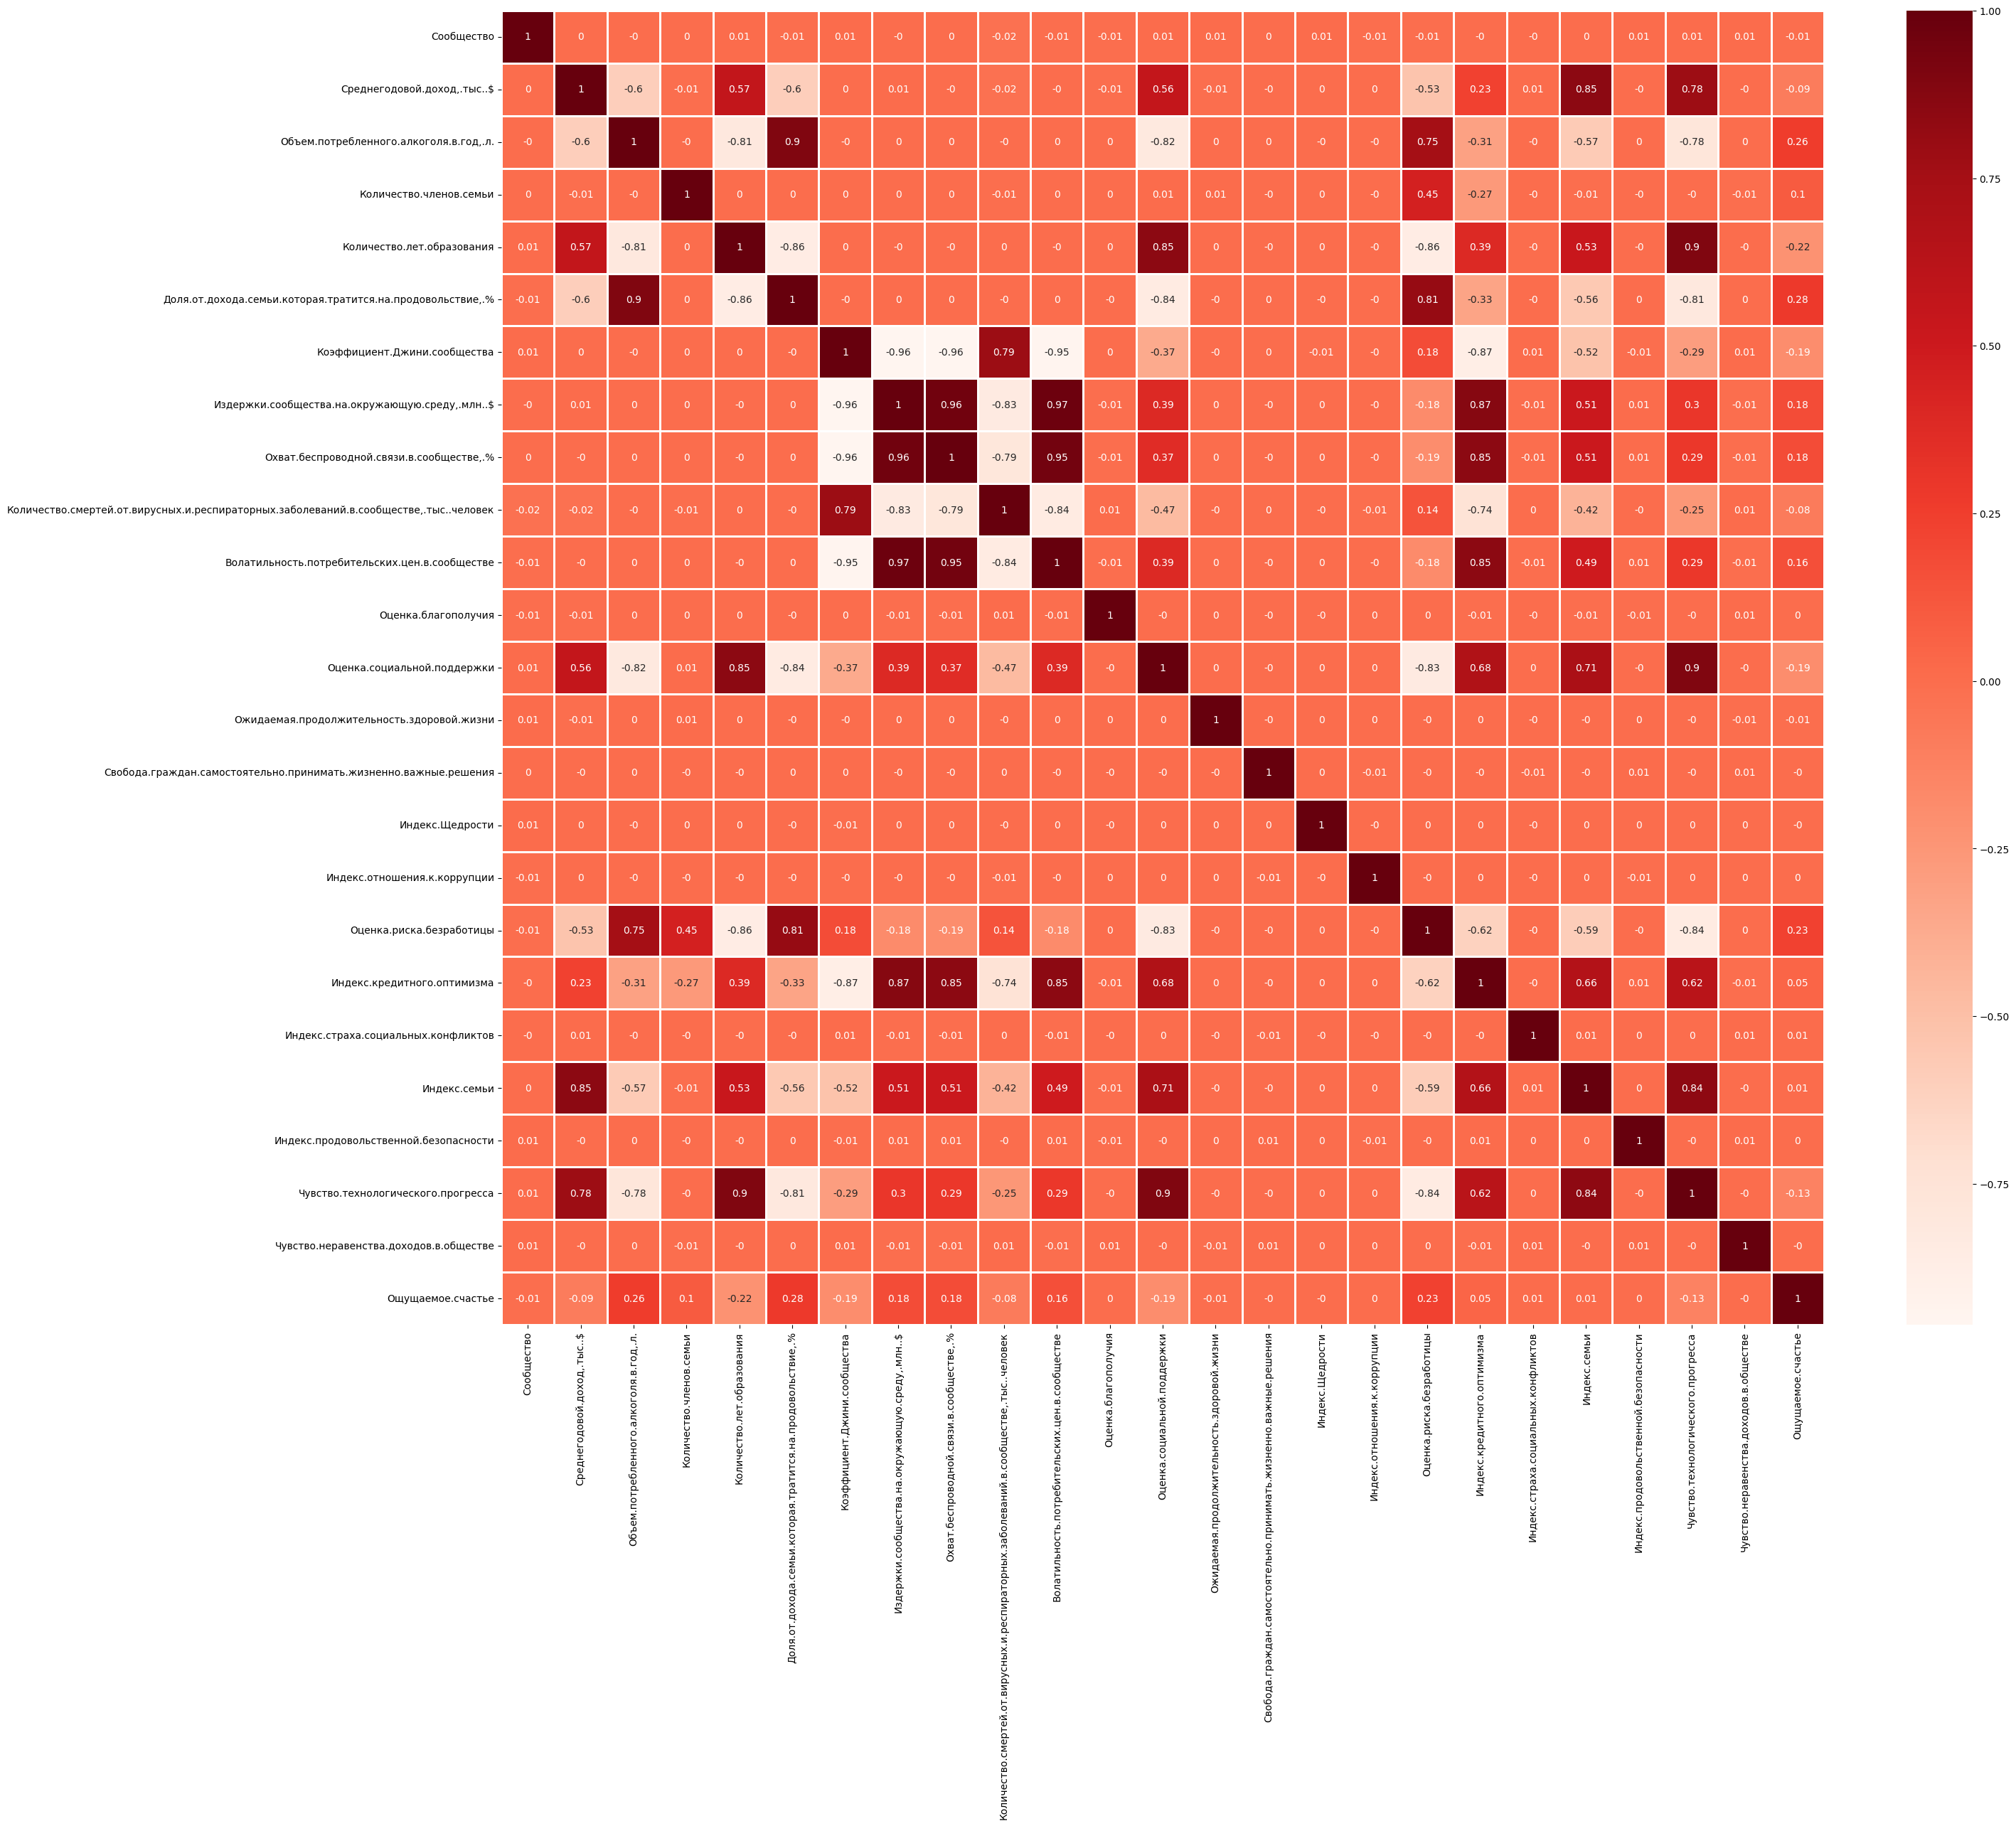

In [ ]:
plt.figure(figsize=(30,24))
sns.heatmap(dataset_knowns.corr().round(decimals=2), annot=True, linewidths=1, cmap='Reds')

In [ ]:
dataset_knowns['Ощущаемое.счастье'] = dataset_knowns['Ощущаемое.счастье'].apply(lambda it: class_names[it])
dataset_knowns

Сообщество  Среднегодовой.доход,.тыс..$  \
0            480                       21.350   
1            130                      622.613   
2            156                      400.896   
3             69                      375.950   
4            330                      925.782   
...          ...                          ...   
35993        450                      458.691   
35994        567                      418.492   
35995        318                      412.715   
35997        331                      374.882   
35999        574                      264.142   

       Объем.потребленного.алкоголя.в.год,.л.  Количество.членов.семьи  \
0                                          62                        4   
1                                          30                        7   
2                                          45                        2   
3                                          56                        5   
4                                          39                        6   
...                                       ...                      ...   
35993                                      47                        1   
35994                                      54                        2   
35995                                      46                        3   
35997                                      38                        1   
35999                                      49                        1   

       Количество.лет.образования  \
0                               5   
1                              21   
2                               8   
3                              10   
4                              18   
...                           ...   
35993                          14   
35994                          11   
35995                          11   
35997                          18   
35999                          15   

       Доля.от.дохода.семьи.которая.тратится.на.продовольствие,.%  \
0                                                     65            
1                                                     39            
2                                                     45            
3                                                     68            
4                                                     38            
...                                                  ...            
35993                                                 50            
35994                                                 47            
35995                                                 50            
35997                                                 39            
35999                                                 45            

       Коэффициент.Джини.сообщества  \
0                          0.608084   
1                          0.369140   
2                          0.345094   
3                          0.635868   
4                          0.787911   
...                             ...   
35993                      0.356139   
35994                      0.841676   
35995                      0.921816   
35997                      0.498873   
35999                      0.561213   

       Издержки.сообщества.на.окружающую.среду,.млн..$  \
0                                               197.16   
1                                               297.10   
2                                               305.32   
3                                                78.78   
4                                                93.35   
...                                                ...   
35993                                           260.35   
35994                                            21.94   
35995                                            59.51   
35997                                           207.14   
35999                                           190.08   

       Охват.беспроводной.связи.в.сообществе,.%  \
0                                    

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset_knowns.drop(['Ощущаемое.счастье'], axis=1), dataset_knowns['Ощущаемое.счастье'])

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

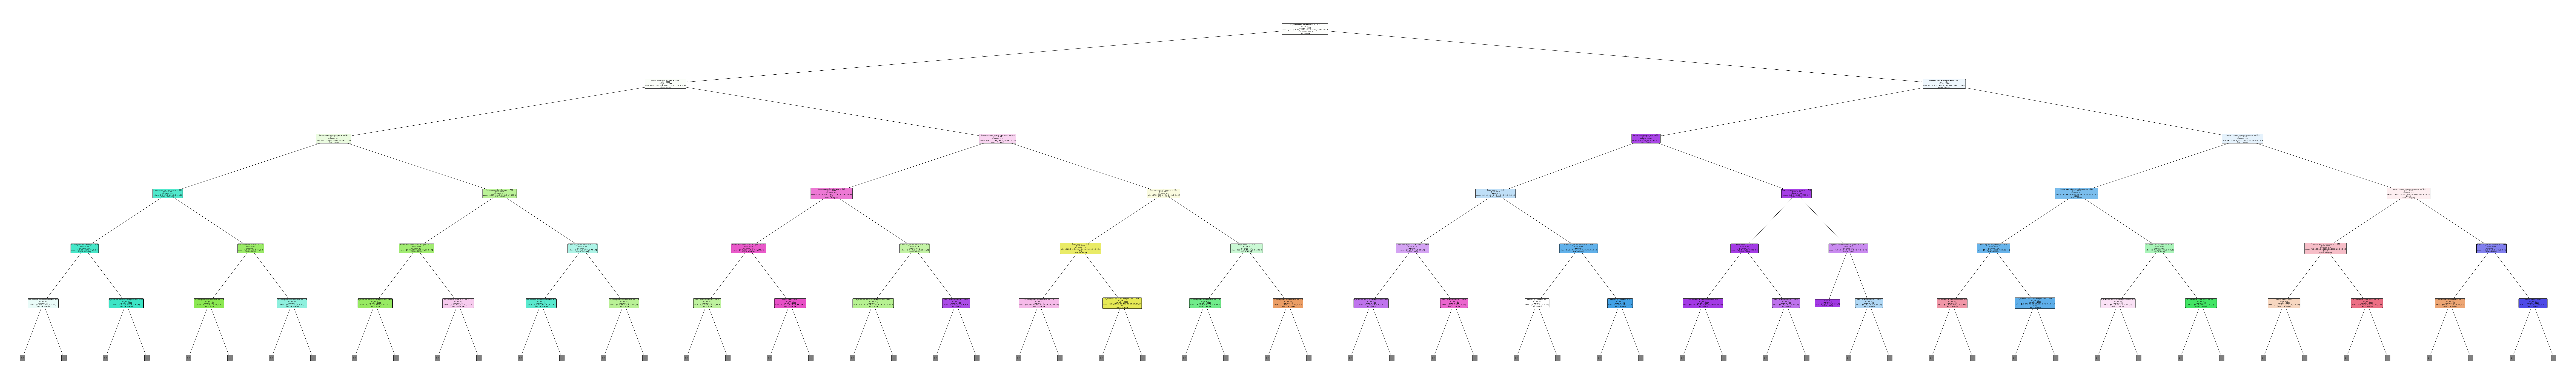

In [ ]:
plt.figure(figsize=(200, 30))
plot_tree(decision_tree, max_depth=5, feature_names=list(dataset), class_names=dataset_knowns['Ощущаемое.счастье'].unique(), filled=True, impurity=True, rounded=True, fontsize=6)
plt.savefig("output.pdf", format="pdf")

In [ ]:
group = {
    'Prospering': 'Thriving',
    'Thriving': 'Thriving',
    'Blooming': 'Thriving',
    'Doing well': 'Thriving',
    'Just ok': 'Strugglng',
    'Coping': 'Strugglng',
    'Strugglng': 'Strugglng',
    'Suffering': 'Suffering',
    'Depressed': 'Suffering',
    'Hopeless': 'Suffering',
}

rank_mapping = {
    'Prospering': 0,
    'Thriving': 1,
    'Blooming': 2,
    'Doing well': 3,
    'Just ok': 4,
    'Coping': 5,
    'Strugglng': 6,
    'Suffering': 7,
    'Depressed': 8,
    'Hopeless': 9,
    'accuracy': 10,
    'macro avg': 11,
    'weighted avg': 12
}

y_test_grouped = itemgetter(*y_test)(group)

def plot_classification(y_test, y_pred, y_test_grouped, y_pred_grouped):
    print(f'MCC: {matthews_corrcoef(y_test, y_pred)}')
    fig, axes = plt.subplots(2, 2, figsize=(17, 10))

    clf_report = classification_report(y_test, y_pred, output_dict=True)
    clf_report = {k: clf_report[k] for k in sorted(clf_report.keys(), key=lambda v: rank_mapping[v])}

    clf_report_grouped = classification_report(y_test_grouped, y_pred_grouped, output_dict=True)
    clf_report_grouped = {k: clf_report_grouped[k] for k in sorted(clf_report_grouped.keys(), key=lambda v: rank_mapping[v])}

    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, ax=axes[0, 0], annot=True, cmap='Reds')
    sns.heatmap(pd.DataFrame(clf_report_grouped).iloc[:-1, :].T, ax=axes[0, 1], annot=True, cmap='Reds')

    cm_labels = sorted(list(set(y_test)), key=lambda v: rank_mapping[v])
    cm = confusion_matrix(y_test, y_pred, labels=cm_labels)

    cm_labels_grouped = sorted(list(set(y_test_grouped)), key=lambda v: rank_mapping[v])
    cm_grouped = confusion_matrix(y_test_grouped, y_pred_grouped, labels=cm_labels_grouped)

    sns.heatmap(cm, ax=axes[1, 0], xticklabels=cm_labels, yticklabels=cm_labels, annot=True, fmt='d', cmap='Reds')
    sns.heatmap(cm_grouped, ax=axes[1, 1], xticklabels=cm_labels_grouped, yticklabels=cm_labels_grouped, annot=True, fmt='d', cmap='Reds')

    axes[0, 0].set_title('Decision tree classifier (by class)')
    axes[0, 1].set_title('Decision tree classifier (by group)')
    plt.show()

MCC: 0.9033977423197757


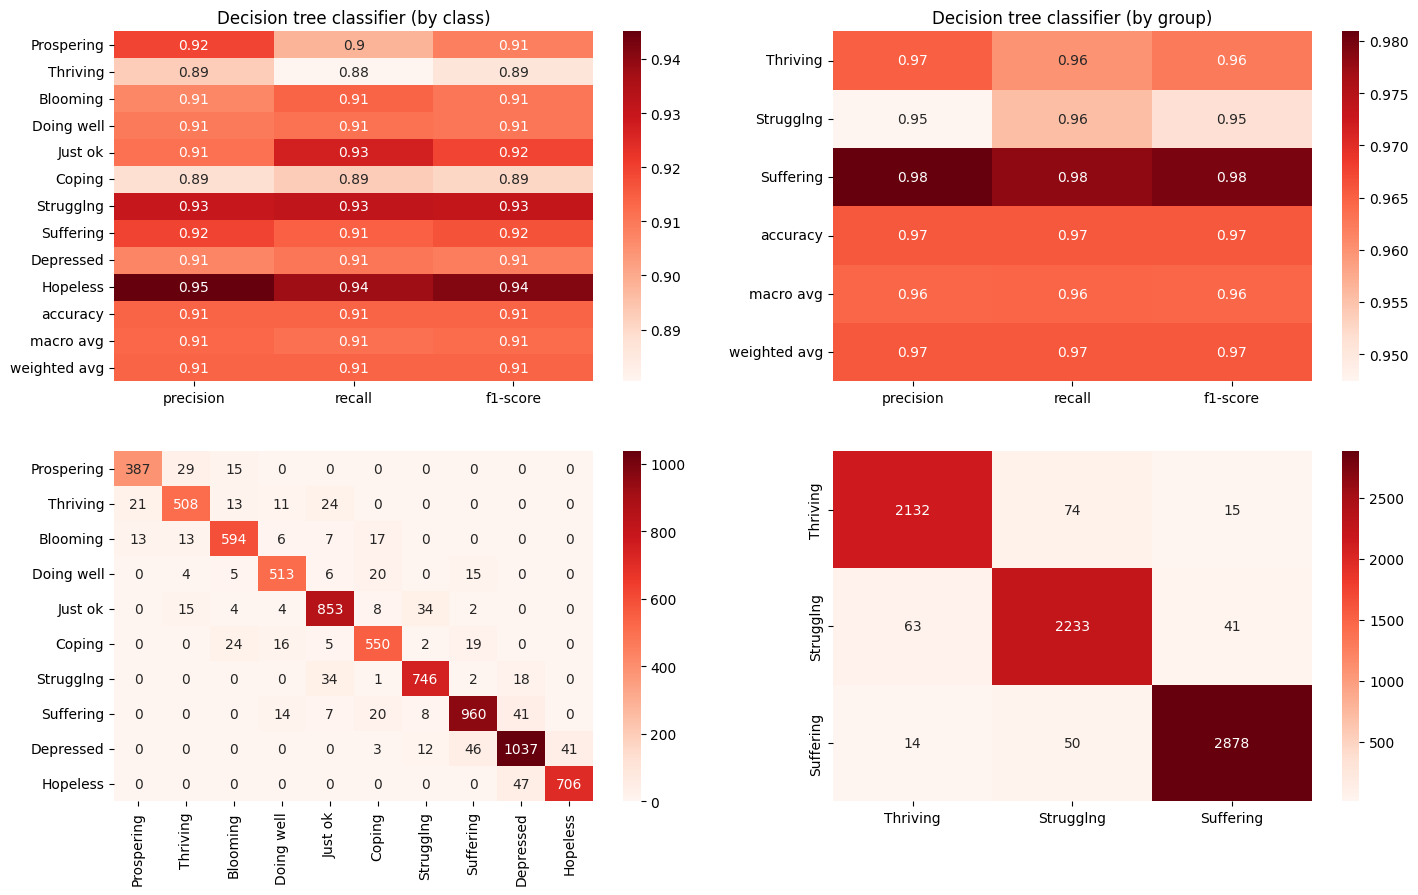

In [ ]:
y_pred = decision_tree.predict(X_test)
y_pred_grouped = itemgetter(*y_pred)(group)
plot_classification(y_test, y_pred, y_test_grouped, y_pred_grouped)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

MCC: 0.8562032149496461


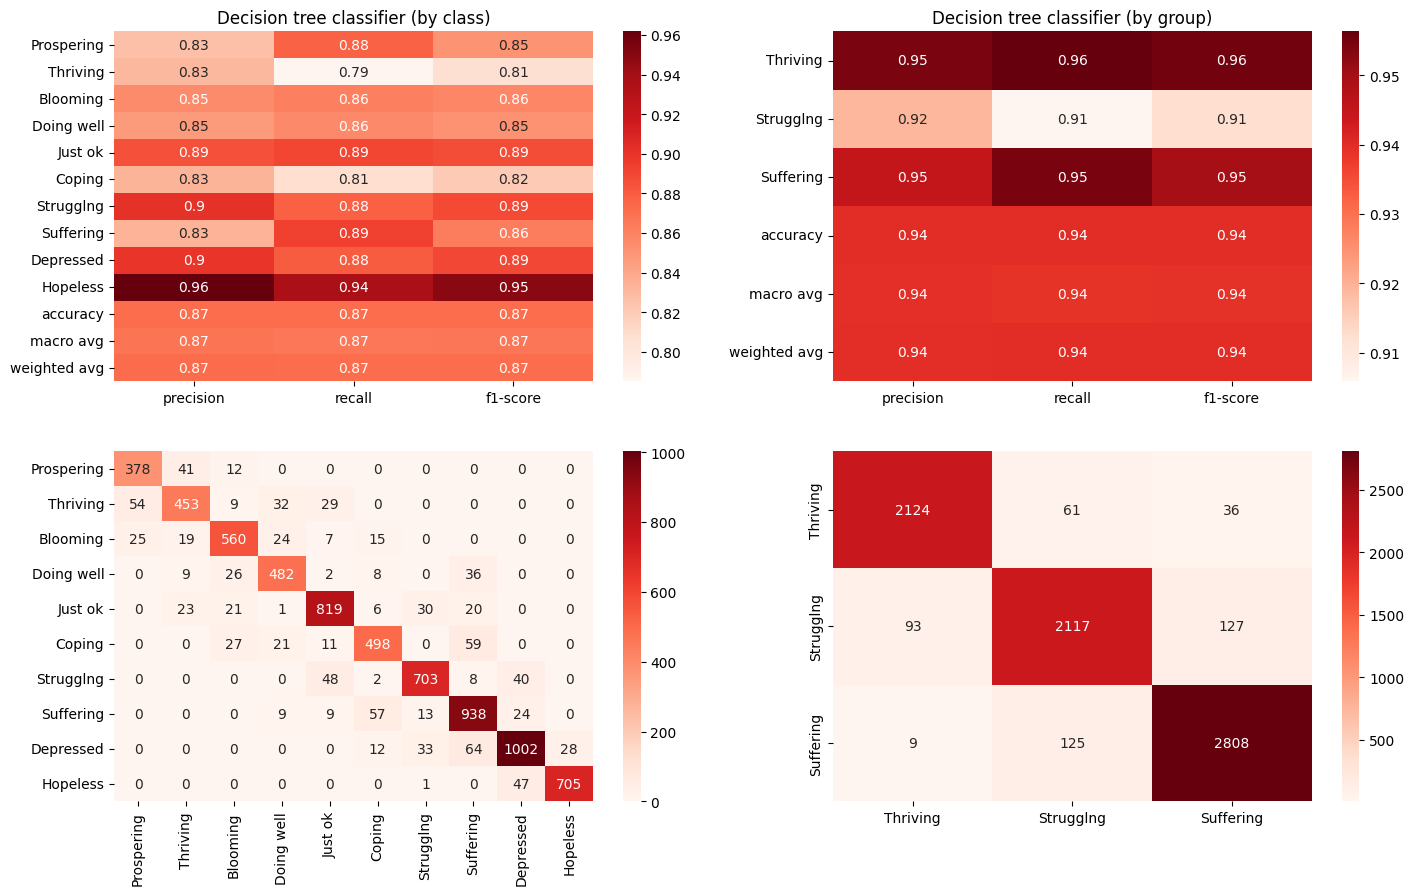

In [ ]:
y_pred = lr.predict(X_test)
y_pred_grouped = itemgetter(*y_pred)(group)
plot_classification(y_test, y_pred, y_test_grouped, y_pred_grouped)

In [ ]:
valid_class_names = list(set(dataset_knowns['Ощущаемое.счастье']))
valid_class_names

['Prospering',
 'Suffering',
 'Depressed',
 'Doing well',
 'Coping',
 'Just ok',
 'Thriving',
 'Blooming',
 'Strugglng',
 'Hopeless']

In [ ]:
y = np.fromiter((valid_class_names.index(elem) for elem in y_train), np.int32) # y_train.apply(lambda it: class_names.index(it))
gbdt = DecisionTreeRegressor()
gbdt.fit(X_train, y)

DecisionTreeRegressor()

MCC: 0.8954770924818121


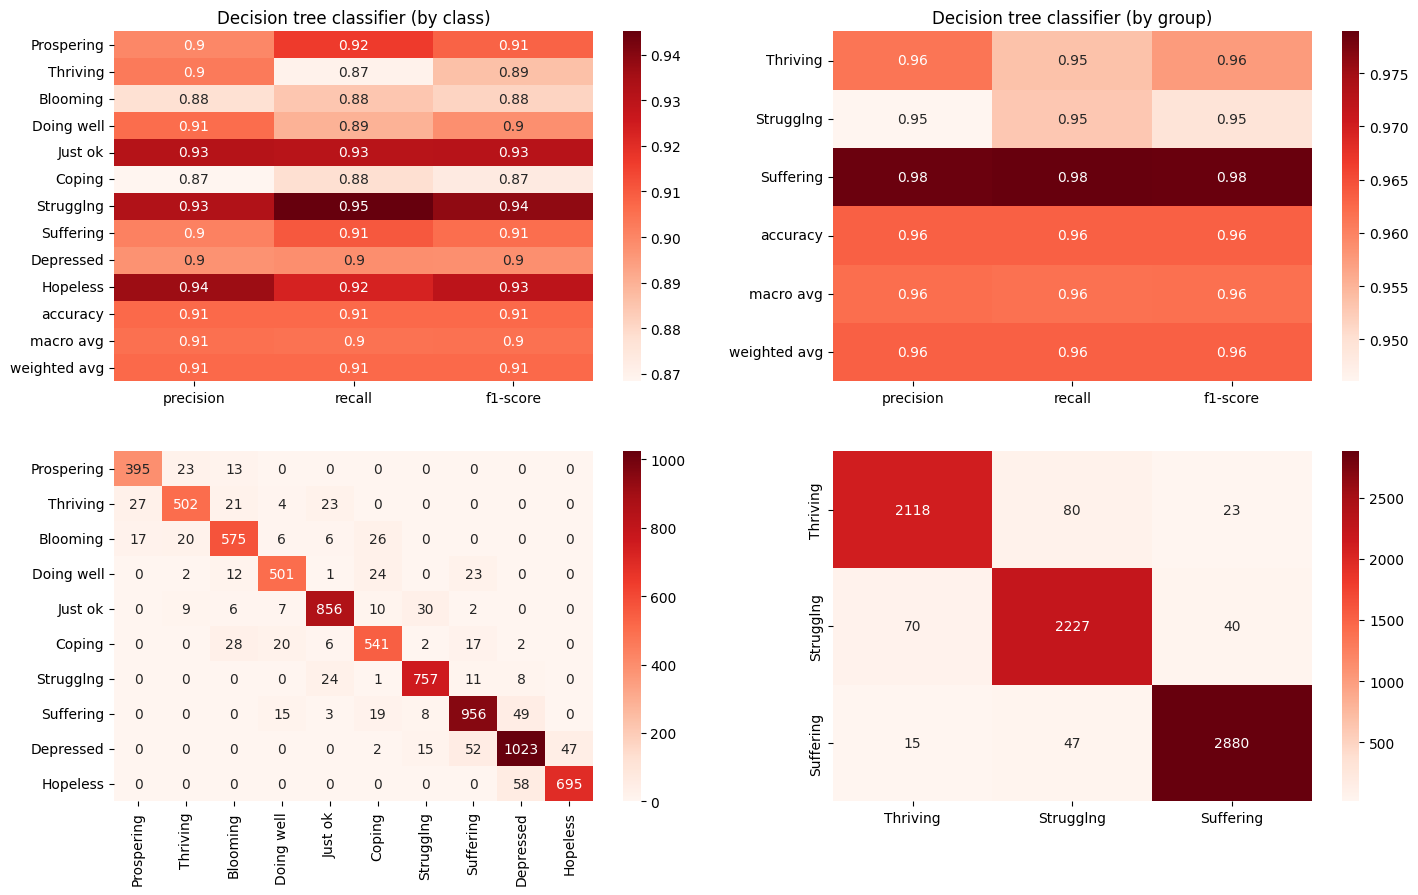

In [ ]:
map_int = {np.int64(k): v for k, v in enumerate(valid_class_names)}
#group_int = {np.int64(k): group[v] for k, v in enumerate(valid_class_names)}
y_pred = gbdt.predict(X_test).astype(np.int64)
y_pred = itemgetter(*y_pred)(map_int)
y_pred_grouped = itemgetter(*y_pred)(group)
plot_classification(y_test, y_pred, y_test_grouped, y_pred_grouped)

### Важно
- **Классификатор** фокусируется на разделении пространства признаков для максимизации чистоты классов;
- **Регрессор** оптимизирует разбиения для минимизации отклонений от среднего значения в подгруппах.

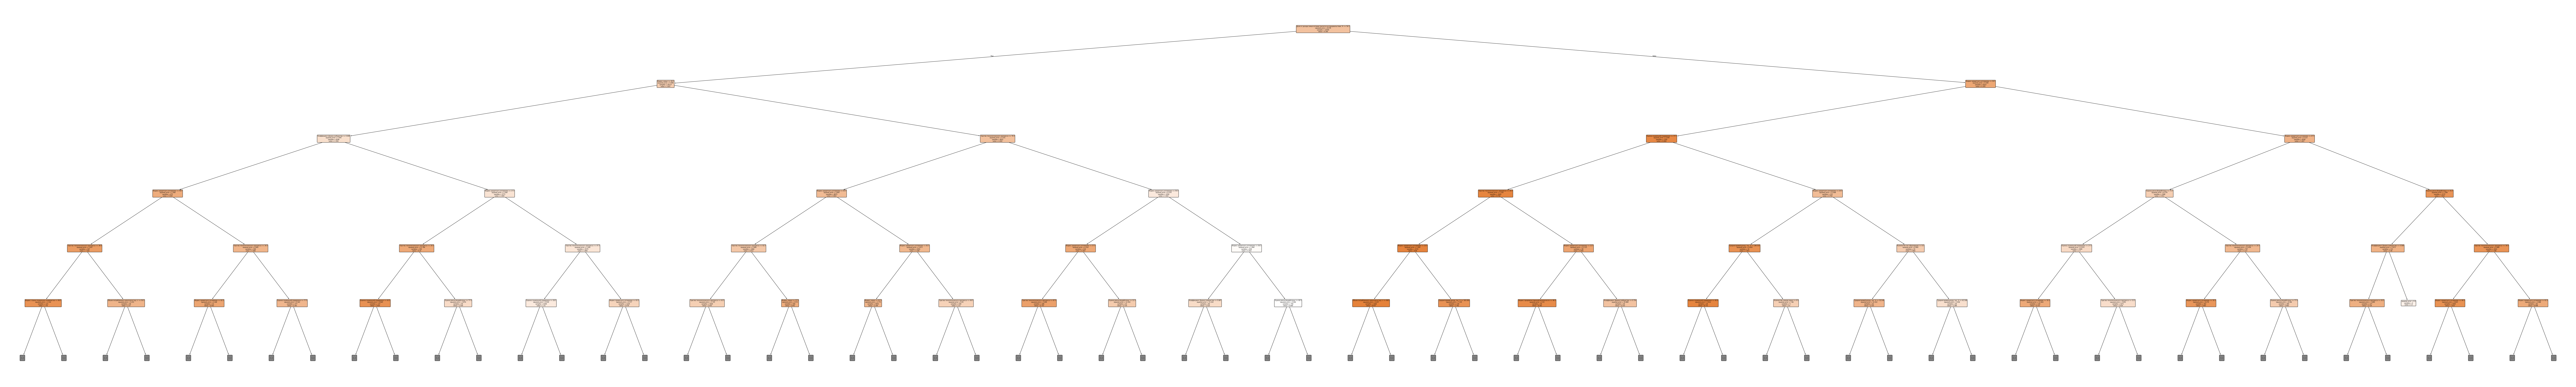

In [ ]:
plt.figure(figsize=(200, 30))
plot_tree(gbdt, max_depth=5, feature_names=list(dataset), class_names=dataset_knowns['Ощущаемое.счастье'].unique(), filled=True, impurity=True, rounded=True, fontsize=6)
plt.savefig("output2.pdf", format="pdf")

In [ ]:
y = np.fromiter((valid_class_names.index(elem) for elem in y_train), np.int32) # y_train.apply(lambda it: class_names.index(it))
abdt = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=250)
abdt.fit(X_train, y)

AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=250)

MCC: 0.9523208274554633


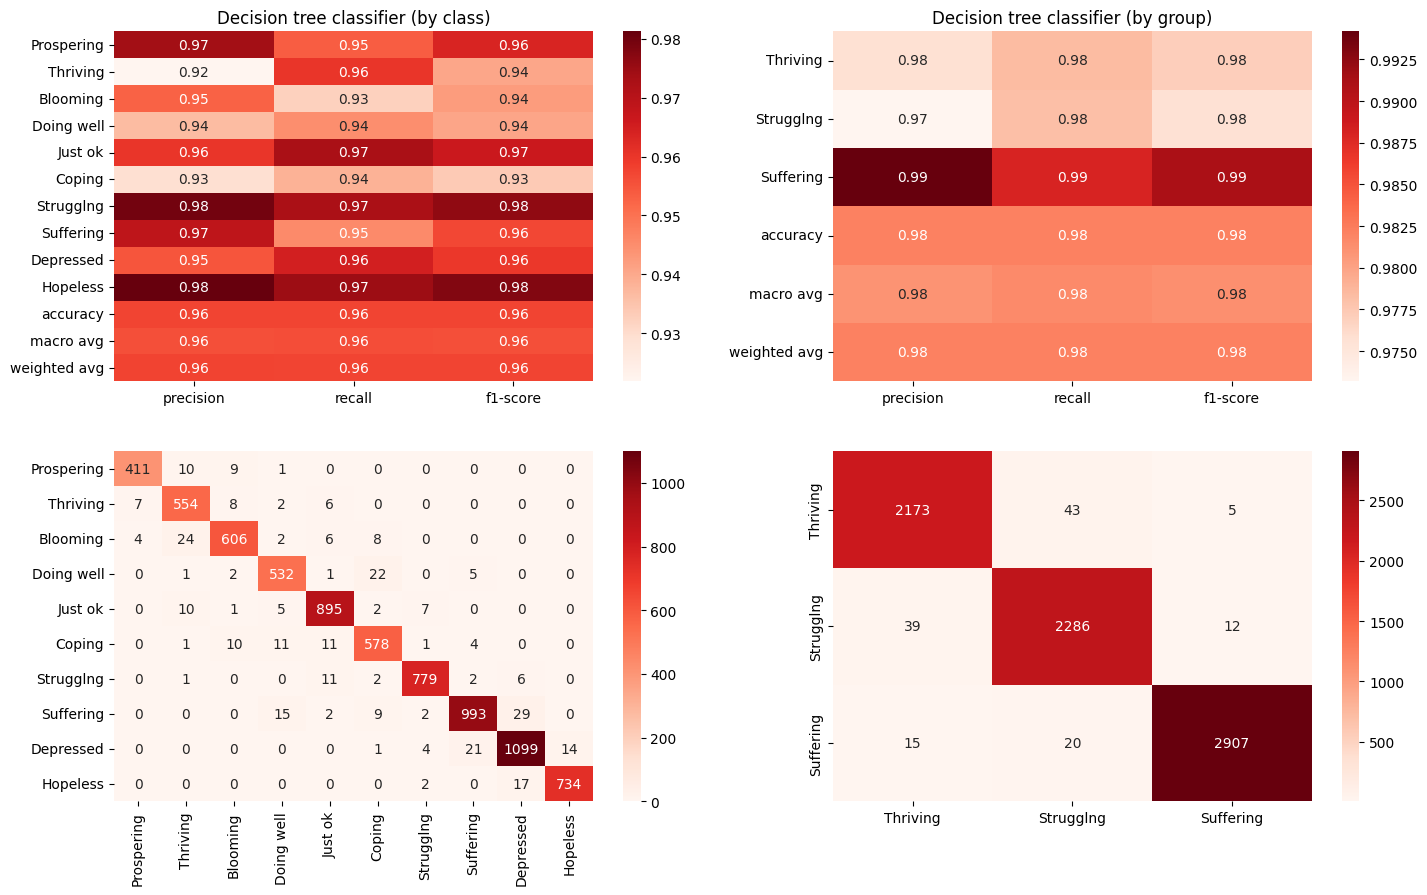

In [ ]:
y_pred = abdt.predict(X_test).astype(np.int64)
y_pred = itemgetter(*y_pred)(map_int)
y_pred_grouped = itemgetter(*y_pred)(group)
plot_classification(y_test, y_pred, y_test_grouped, y_pred_grouped)